# Damage Size Regression on Real-world Data
In this notebook, we conduct experiments on real-world data with models trained on solely synthetic data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_AB.ipynb)

In [1]:
random_state = 42

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    %pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    %pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [22]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH, real_data_path=REAL_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_real_regression_scoring,
    SHM_Scoring)
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from shm_experiments import conduct_ab_mixed_reg_experiment

time passed: 14.53 s
downloading synthetic data successful: True
time passed: 3.11 s
downloading real world data successful: True


In [5]:
result_file = "mixed_regression_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

### Synthetic Data

In [6]:
Xsyn, ysyn = load_syn_reg_data(data_path=SYN_DATA_PATH,
                               min_radius = 1.9,
                               cache=True)

In [7]:
Xsyn.shape

(28302, 31)

In [8]:
ctr = Counter(ysyn)
ctr

Counter({0.0: 990,
         3.1: 986,
         28.0: 983,
         6.7: 981,
         16.0: 980,
         24.0: 980,
         2.2: 979,
         2.5: 979,
         4.4: 979,
         2.8: 978,
         14.0: 978,
         5.0: 977,
         30.0: 977,
         4.1: 976,
         4.7: 976,
         18.0: 976,
         36.0: 976,
         22.0: 975,
         20.0: 974,
         3.8: 973,
         10.0: 973,
         26.0: 973,
         3.4: 972,
         8.3: 972,
         34.0: 971,
         12.0: 969,
         40.0: 968,
         32.0: 967,
         38.0: 964})

### Real World Data

In [9]:
Xreal, yreal = load_syn_reg_data(data_path=REAL_DATA_PATH,
                                 min_radius = 1.,
                                 synthetic=False,
                                 calibration_file=CALIBRATION_FILE)

In [10]:
Xreal.shape

(225, 31)

In [11]:
ctr = Counter(yreal)
ctr

Counter({0.0: 9,
         1.5: 9,
         10.0: 9,
         12.0: 9,
         14.0: 9,
         16.0: 9,
         17.0: 9,
         19.0: 9,
         2.5: 9,
         21.0: 9,
         23.0: 9,
         25.0: 9,
         27.0: 9,
         29.0: 9,
         3.5: 9,
         31.0: 9,
         33.0: 9,
         35.0: 9,
         37.0: 9,
         39.0: 9,
         4.5: 9,
         40.0: 9,
         5.5: 9,
         7.0: 9,
         8.0: 9})

In [12]:
normal_real_indices = yreal==0.0
normal_syn_indices = ysyn==0.0
X = np.concatenate([Xreal[normal_real_indices], Xsyn[normal_syn_indices]], axis=0)
y = np.concatenate([np.repeat('real', np.sum(normal_real_indices)),
                    np.repeat('synthetic', np.sum(normal_syn_indices))])

target_col = "origin"

df_X = pd.DataFrame(X)

df_y = pd.DataFrame(columns=[target_col])
df_y[target_col] = y

df = pd.concat([df_X, df_y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       999 non-null    float32
 1   1       999 non-null    float32
 2   2       999 non-null    float32
 3   3       999 non-null    float32
 4   4       999 non-null    float32
 5   5       999 non-null    float32
 6   6       999 non-null    float32
 7   7       999 non-null    float32
 8   8       999 non-null    float32
 9   9       999 non-null    float32
 10  10      999 non-null    float32
 11  11      999 non-null    float32
 12  12      999 non-null    float32
 13  13      999 non-null    float32
 14  14      999 non-null    float32
 15  15      999 non-null    float32
 16  16      999 non-null    float32
 17  17      999 non-null    float32
 18  18      999 non-null    float32
 19  19      999 non-null    float32
 20  20      999 non-null    float32
 21  21      999 non-null    float32
 22  22

In [13]:
ctr = Counter(df[target_col])
ctr

Counter({'synthetic': 990, 'real': 9})

## Calibration check
We plot the mean and standard deviation of only pristine samples of synthetic and real-world data.

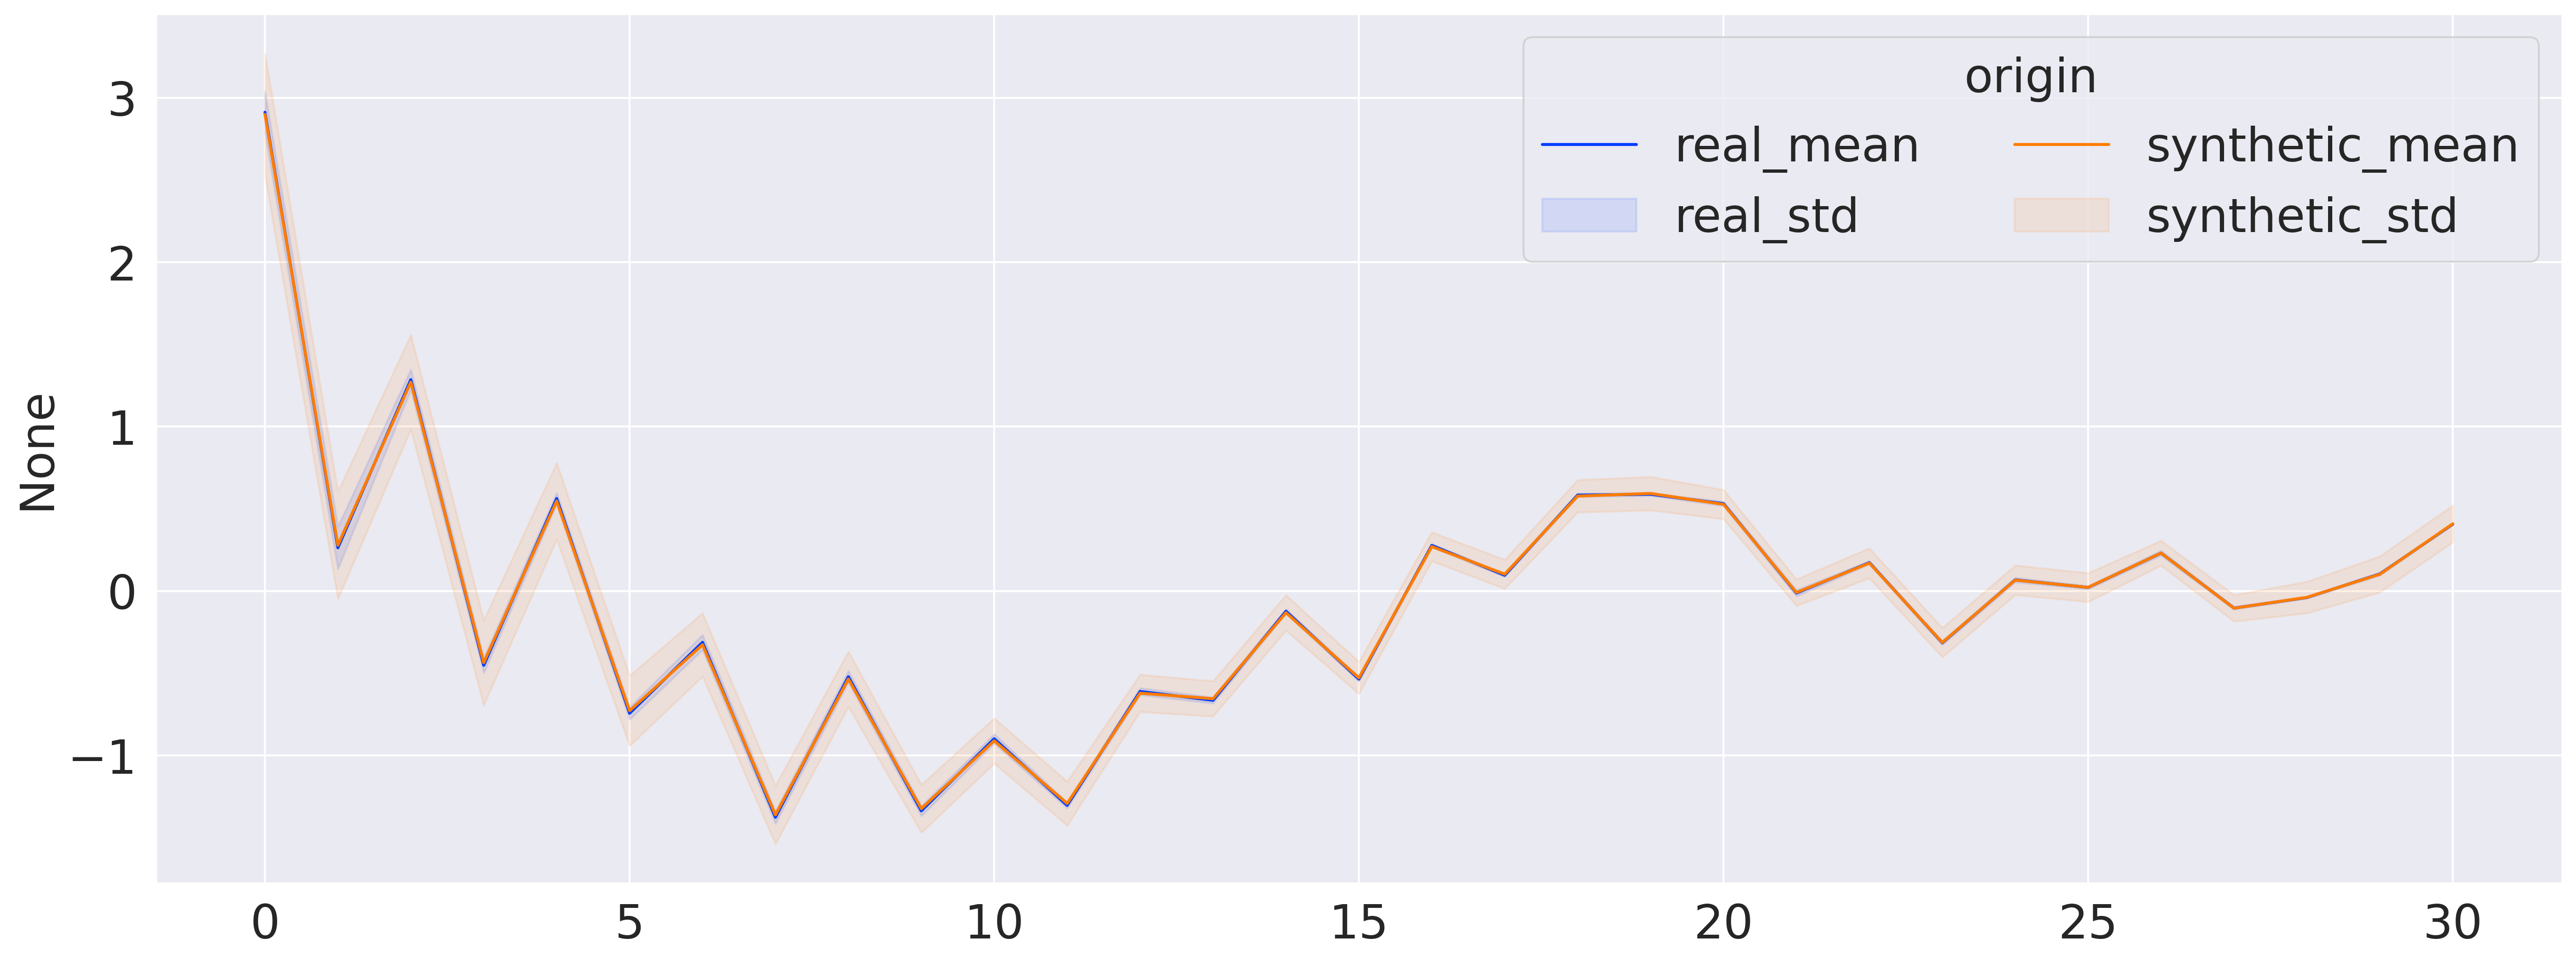

In [14]:
from plot_utils import plot_classwise_dist

fig = plot_classwise_dist(df=df, label_col=target_col)
fig.gca().legend(ncol=2, loc='best', title=target_col);

## A-B Experiments

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [16]:
estimator = SVR(kernel='rbf', C=50, gamma='scale', epsilon=.1)
pipeline = Pipeline([('est', estimator)])
svmrbf_pipeline = [("SVR", pipeline)]

In [17]:
estimator = KNeighborsRegressor(n_neighbors=1)
pipeline = Pipeline([('est', estimator)])

knn_pipeline_1 = [("KNN_1", pipeline)]

In [18]:
estimator = MLPRegressor(hidden_layer_sizes=(48,), learning_rate="adaptive")
pipeline = Pipeline([('est', estimator)])

mlp_pipeline_48 = [("MLP_48", pipeline)]

In [19]:
estimator = MLPRegressor(hidden_layer_sizes=(64,32,), learning_rate="adaptive")
pipeline = Pipeline([('est', estimator)])

mlp_pipeline_64_32 = [("MLP_64.32", pipeline)]

In [20]:
scoring = get_real_regression_scoring()

start_time = time.perf_counter()
results = conduct_ab_mixed_reg_experiment(Xsyn=Xsyn, ysyn=ysyn,
                                          Xreal=Xreal, yreal=yreal,
                                          estimators=[knn_pipeline_1,
                                                      svmrbf_pipeline,
                                                      mlp_pipeline_48,
                                                      mlp_pipeline_64_32],
                                          n_splits=32,
                                          test_size=0.1,
                                          scoring=scoring,
                                          random_state=random_state)
end_time = time.perf_counter()
print(f"time passed: {end_time-start_time:.2f} s")

KeyboardInterrupt: 

## Store results for later

In [ ]:
results.to_pickle(result_file)

## Plot some results for overview

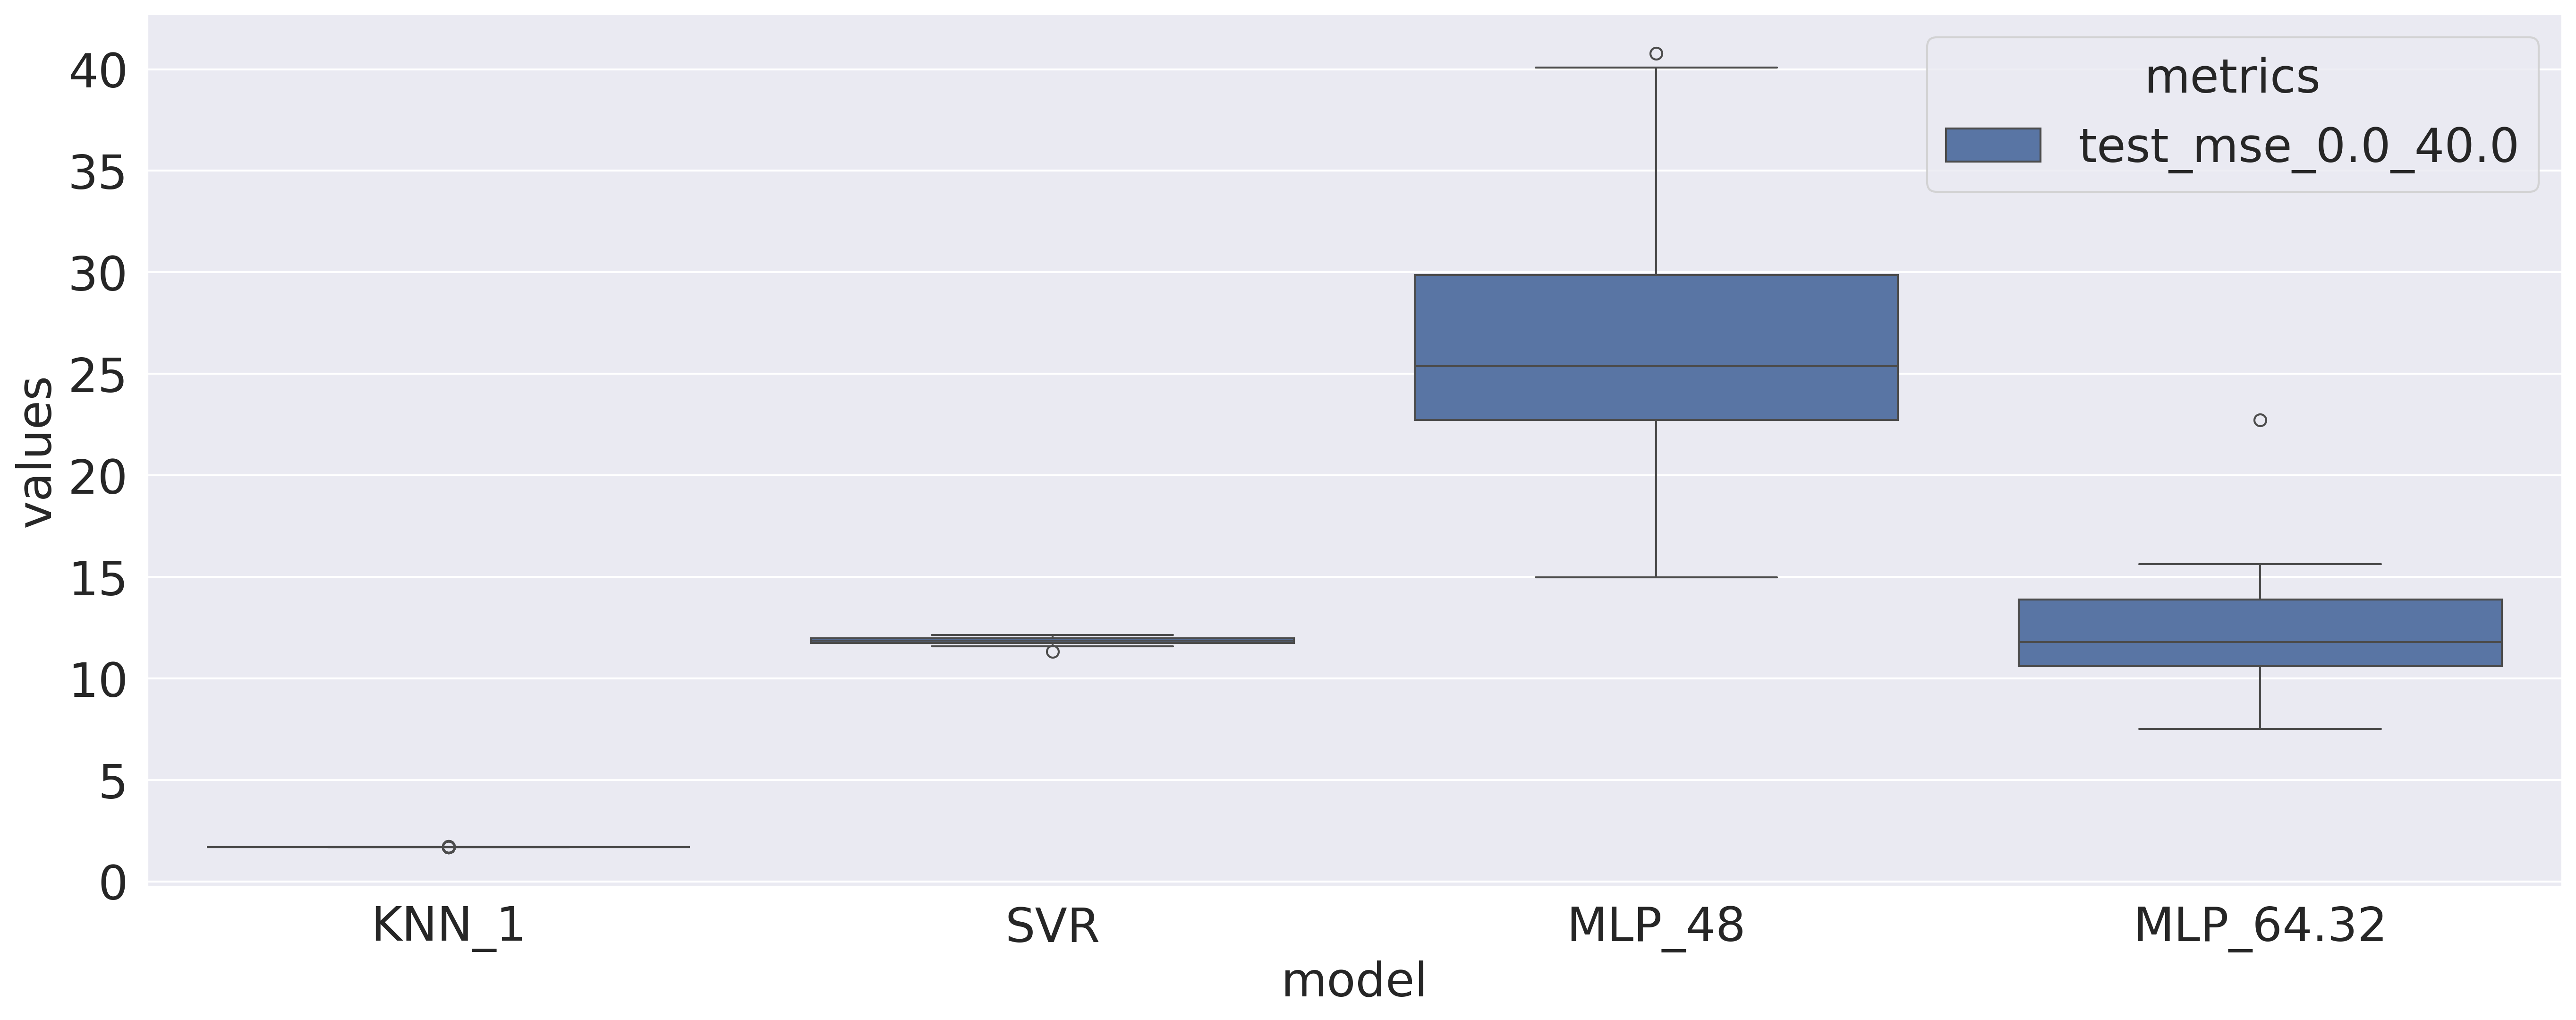

In [ ]:
fig = plot_metrics(extract_metrics(results, ['test_mse_0.0_40.0']))
plt.show()

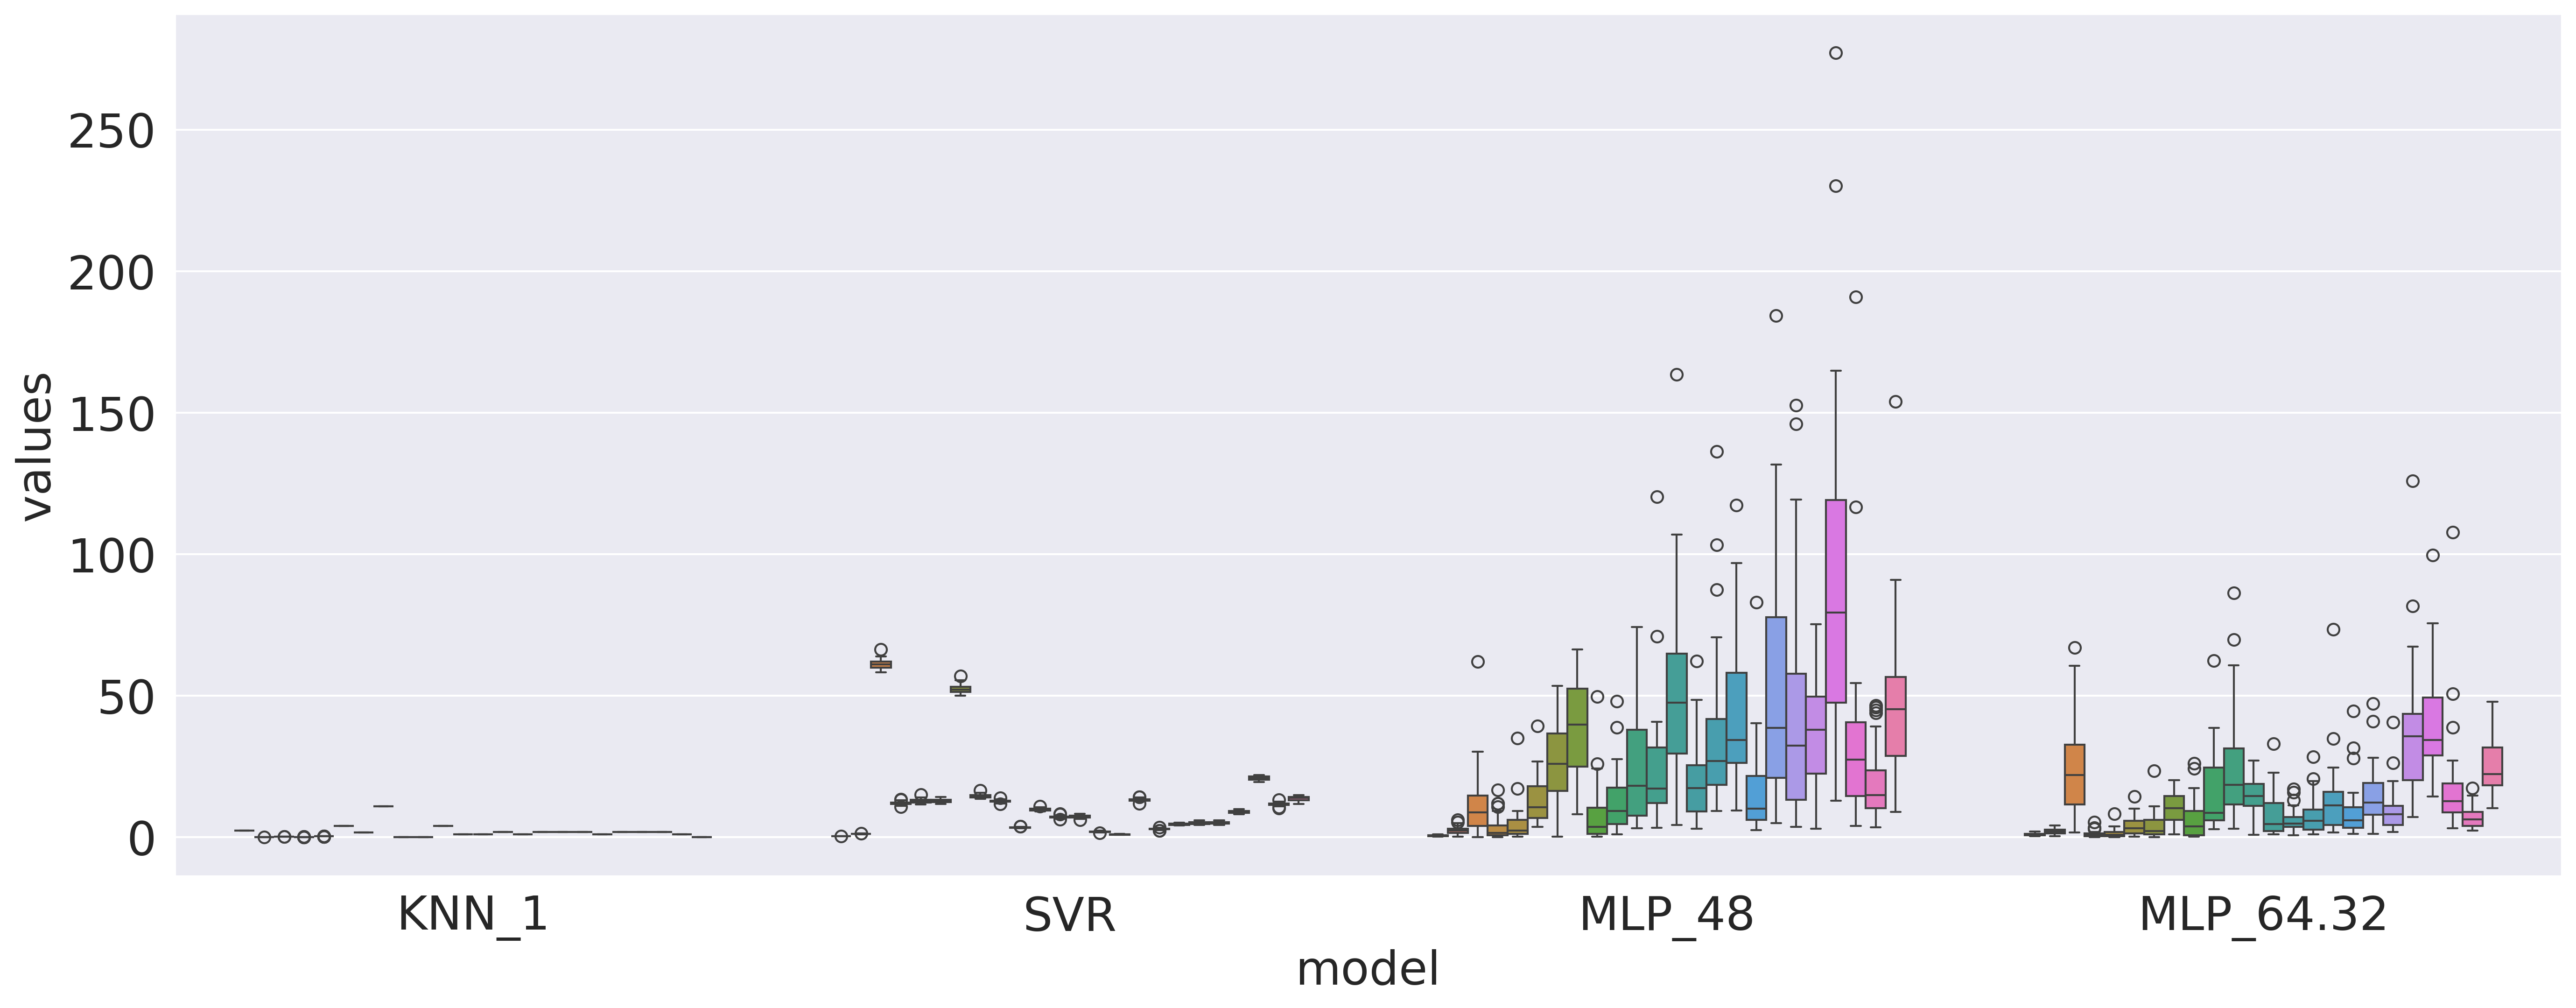

In [ ]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
plt.gca().get_legend().remove()
plt.show()

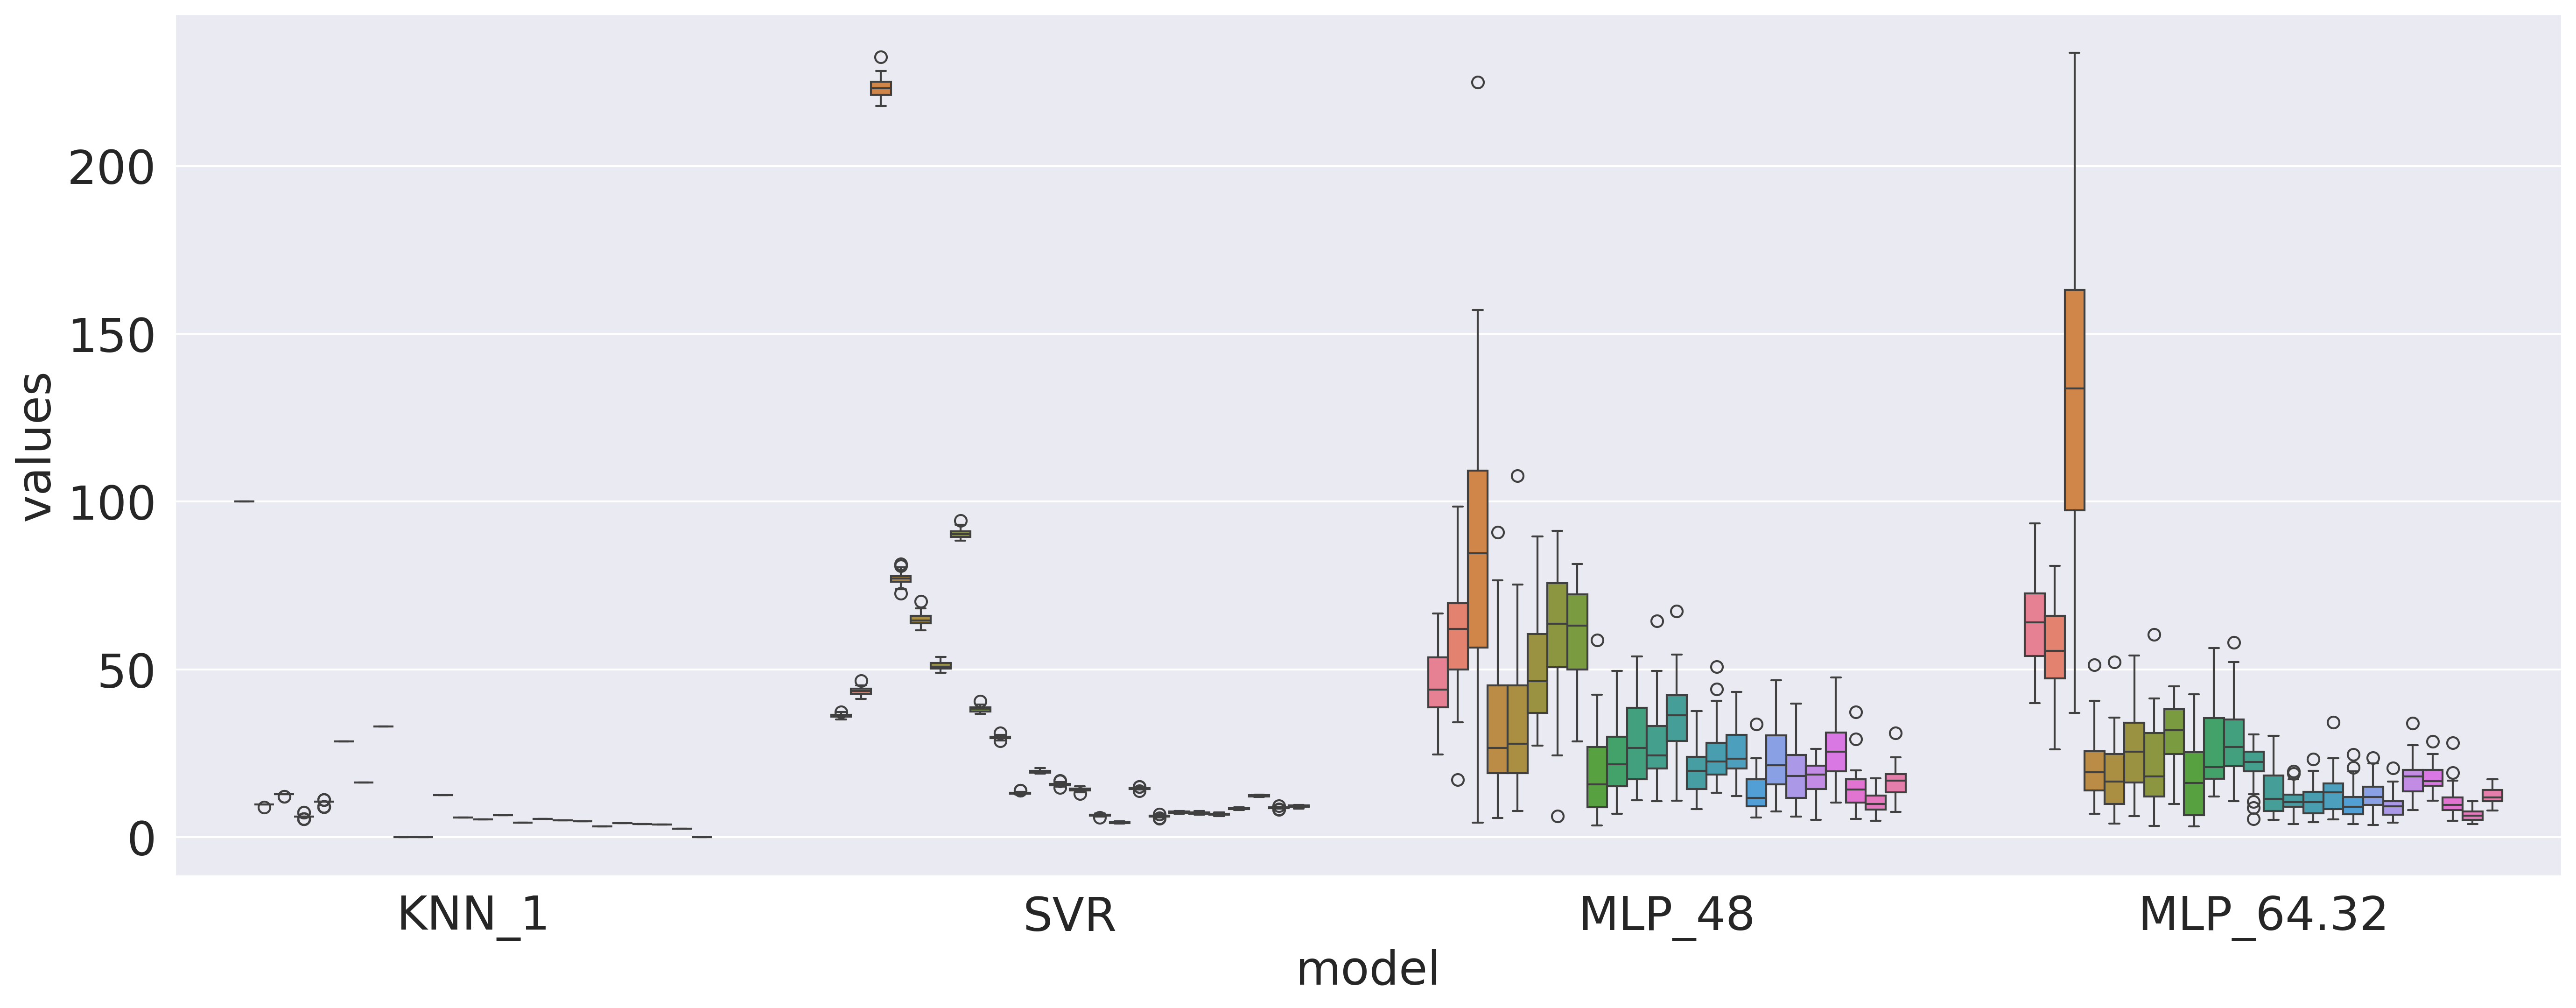

In [ ]:
fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
plt.gca().get_legend().remove()
plt.show()